In [2]:
import os
import glob
import math
import time
import numpy as np
import numpy.matlib
import pandas as pd
from scipy.stats import entropy
from collections import Counter
from functools import reduce
import matplotlib.pyplot as plt
import networkx as nx
from pandas.plotting._matplotlib.style import get_standard_colors

In [25]:
def construct_full_JDAM_from_adj(adj, labels):
    if isinstance(labels, list):
        labels = np.array(labels)
    degree = adj.sum(axis=0)
    num_edges = adj.sum()
    # remaining degree distribution of the network 
    qk = {degree - 1: degree * count / num_edges for degree, count in Counter(degree).items()}
    comat_full = np.zeros((len(qk)*2, len(qk)*2))

    rows, cols = adj.nonzero()
    for i in range(adj.shape[0]):
        label_i = labels[i]
        degree_i = degree[i]
        for j in cols[rows == i]: # for j in np.arange(adj.shape[1]):
            label_j = labels[j]
            degree_j = degree[j]
            comat_full[label_i * len(qk) + list(qk.keys()).index(degree_i - 1), label_j * len(qk) + list(qk.keys()).index(degree_j - 1)] += adj[i, j]

    return comat_full


def MI_JDAM(*args, verbose_MI=False, verbose_SVD=False):
    # Reconstruct the complete joint degree and attribute matrix
    if len(args) == 3:
        comat, degm, degf = args
        if isinstance(comat, list):
            comat = np.array(comat)
        comat_full = construct_full_JDAM_from_comat(comat, degm, degf)

    elif len(args) == 2:
        adj, labels = args
        if isinstance(labels, list):
            labels = np.array(labels, dtype=bool)        
        comat_full = construct_full_JDAM_from_adj(adj, labels)

    # Compute the mutual information of the joint degree distribution and the single degree distribution    
    n = comat_full.shape[0] // 2
    ejk = comat_full[:n] + comat_full[n:]
    ejk = ejk[:, :n] + ejk[:, n:]
    qk = ejk.sum(axis=0)
    I1 = entropy(ejk.flatten(), (qk.reshape(-1, 1) @ qk.reshape(1, -1)).flatten(), base=2)

    # Compute the mutual information of the joint (degree, attributes) distribution and the single degree distribution
    pjcj = comat_full.sum(axis=0)
    I2 = entropy(comat_full.flatten(), (pjcj.reshape(-1, 1) @ pjcj.reshape(1, -1)).flatten(), base=2)

    if verbose_MI:
        print(f"I2 = {I2} >= I1 = {I1}.")
    return I2 - I1, I2, I1

In [26]:
for fname in glob.glob(os.path.join("*.csv")):
    if "economics" in fname:
        continue
    if "aps" in fname:
        citation = pd.read_csv(fname)
    else:
        citation = pd.read_csv(fname, index_col=[0])
    
    # remove NAN entries and other meaningless entries; keep only year 2003 - 2012
    citation_valid = citation[(citation['to_author_gender']!='not_in_db') & (citation['from_author_gender']!='not_in_db') &
                              (citation['to_author_gender']!='unknown') & (citation['from_author_gender']!='unknown') &
                              (citation['to_author_gender']!='andy') & (citation['from_author_gender']!='andy')]
    citation_valid = citation_valid[~citation_valid['year'].isnull()]
    citation_valid = citation_valid[(citation_valid['year'] > 2002) & (citation_valid['year'] < 2019)]
    
    # compute the rational attention for the dataset
    results = pd.DataFrame(columns=['year', 'RA(t=T)', 'I1', 'I2'])
    row_id = 0
    for year in range(2003, 2019):
        citation_per_year = citation_valid[citation_valid['year']==year]
        edge_list = citation_per_year[['from_author', 'to_author']].loc[citation_per_year.index.repeat(citation_per_year.times)].values
        print(f"---- year {year}: {len(edge_list)} edges ----")
        G = nx.from_edgelist(edge_list)
        adj = nx.to_scipy_sparse_array(G) # nx.to_numpy_array(G)
        print(f"shape of the adjacency matrix: {adj.shape}")
        ordering = list(G.nodes())

        dict1 = pd.Series(citation_per_year['from_author_gender'].values, index=citation_per_year['from_author'].values).to_dict()
        dict2 = pd.Series(citation_per_year['to_author_gender'].values, index=citation_per_year['to_author'].values).to_dict()
        dict_gender = {**dict1, **dict2}
        dict_gender = {id: 0 if gender=='male' or gender=='mostly_male' else 1 for id, gender in dict_gender.items()}
        labels = [dict_gender[author] for author in ordering]
        
        tic = time.time()
        RAt, I2, I1 = MI_JDAM(adj, labels)
        print(f"Rational attention: {RAt}; computation time: {time.time() - tic} s")
        results.at[row_id] = [year, RAt, I1, I2]
        row_id += 1
        
    results.to_csv(fname.split(".csv")[0] + "_rational_attention.csv")

---- year 2003: 295601 edges ----
shape of the adjacency matrix: (26381, 26381)
Rational attention: 0.1047597368011603; computation time: 19.305441856384277 s
---- year 2004: 359708 edges ----
shape of the adjacency matrix: (29917, 29917)
Rational attention: 0.09776315381238879; computation time: 23.503685235977173 s
---- year 2005: 450410 edges ----
shape of the adjacency matrix: (34340, 34340)
Rational attention: 0.10445046817778036; computation time: 35.6731743812561 s
---- year 2006: 501921 edges ----
shape of the adjacency matrix: (36890, 36890)
Rational attention: 0.099807496947003; computation time: 40.09594511985779 s
---- year 2007: 550967 edges ----
shape of the adjacency matrix: (39803, 39803)
Rational attention: 0.10475114905173191; computation time: 45.70501184463501 s
---- year 2008: 681836 edges ----
shape of the adjacency matrix: (43655, 43655)
Rational attention: 0.10047961001253758; computation time: 57.05917024612427 s
---- year 2009: 751259 edges ----
shape of the a

Rational attention: 0.1217622078638414; computation time: 32.4701566696167 s
---- year 2007: 368826 edges ----
shape of the adjacency matrix: (56881, 56881)
Rational attention: 0.11685770843237536; computation time: 34.172914028167725 s
---- year 2008: 422641 edges ----
shape of the adjacency matrix: (66208, 66208)
Rational attention: 0.12404934787150457; computation time: 51.30396389961243 s
---- year 2009: 494552 edges ----
shape of the adjacency matrix: (71533, 71533)
Rational attention: 0.12176440457683063; computation time: 71.77589249610901 s
---- year 2010: 569137 edges ----
shape of the adjacency matrix: (78011, 78011)
Rational attention: 0.1305829472673375; computation time: 89.30035710334778 s
---- year 2011: 614373 edges ----
shape of the adjacency matrix: (87269, 87269)
Rational attention: 0.12109326678166094; computation time: 102.58363032341003 s
---- year 2012: 720096 edges ----
shape of the adjacency matrix: (96140, 96140)
Rational attention: 0.11761801558398857; comput

In [25]:
glob.glob(os.path.join("*rational_attention.csv"))

['aps_author_citation_genderrational_attention.csv',
 'management_author_citation_genderrational_attention.csv',
 'political_science_author_citation_genderrational_attention.csv',
 'psychology_author_citation_genderrational_attention.csv',
 'statistics_rational_attention.csv']

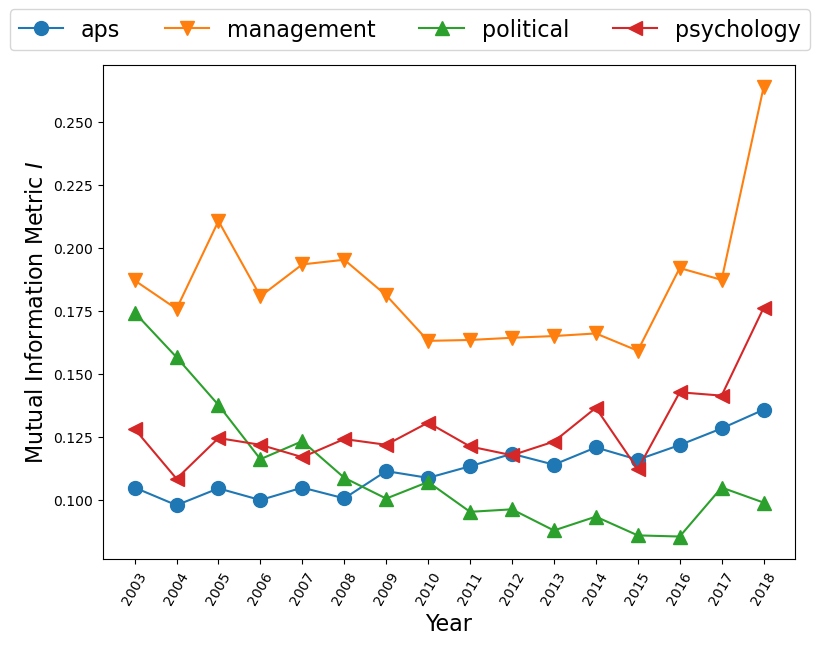

In [25]:
fontsize = 16
markersize = 10
fig, ax = plt.subplots(figsize=(8, 6))
colors = get_standard_colors(len(glob.glob(os.path.join("*rational_attention.csv"))))
markers = ["o", "v", "^", "<", ">", "s", "p", "*"]

for i, fname in enumerate(glob.glob(os.path.join("*rational_attention.csv"))):
    subject = fname.split('_')[0]
    result = pd.read_csv(fname, index_col=[0])
    if "statistics" in fname:
        continue
        ax1 = ax.twinx()
        ax1.plot(result['year'].values, result['RA(t=T)'].values, marker=markers[i], color=colors[i], markersize=markersize, label=subject)
        ax1.tick_params(axis='y', labelcolor=colors[i])
    else:
        ax.plot(result['year'].values, result['RA(t=T)'].values, marker=markers[i], color=colors[i], markersize=markersize, label=subject)

# fig.legend(loc='upper left', bbox_to_anchor=(0.1, 1.1), fontsize=fontsize)
fig.legend(bbox_to_anchor=(0, 1.0, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=4, fontsize=fontsize)
# fig.subplots_adjust(right=0.2)
ax.set_xticks(np.arange(2003,2019, dtype=int))
ax.set_xticklabels(np.arange(2003,2019, dtype=int), rotation=60)
ax.set_xlabel('Year', fontsize=fontsize) # ax.xaxis.label.set_size(14)
ax.set_ylabel(r'Mutual Information Metric $I$', fontsize=fontsize)
plt.tight_layout()
fig.savefig('MI_increase_by_year_citation_per_subject_no_stats_2018.png', bbox_inches="tight", dpi=100)
